# Medical Q&A RAG
By: Thomas Powell and Emiliano Vega

In [ ]:
# Hugging Face Token Access
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `MedicalQ&A` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `MedicalQ&A`


In [ ]:
!pip install accelerate kaggle faiss-cpu evaluate rouge_score --upgrade transformers

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:

In [ ]:
!git clone https://github.com/google-research/bleurt.git
!pip install bleurt/.

Cloning into 'bleurt'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 134 (delta 0), reused 17 (delta 0), pack-reused 116 (from 1)
Receiving objects: 100% (134/134), 31.28 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Processing ./bleurt
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456766 sha256=9c5faba8ea1a4ec1543a12b7711ca1692a01092dfd573ed753e5b5fb9b221b8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-92i0qxdz/wheels/49/ab/73/9318ab38d4cd1c732bcea8335d3f8d7c0316c8d07b9084fa85
Successfully built BLEURT


In [ ]:
import pandas as pd
import numpy as np
import torch
import zipfile
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
import faiss
import requests
import html
import xml.etree.ElementTree as ET
import re
import evaluate
from rouge_score import rouge_scorer, scoring
from bleurt import score
import matplotlib.pyplot as plt

## Data Preparation

###Medquad CSV

In [ ]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/ # Manually upload your kaggle token
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jpmiller/layoutlm -f medquad.csv # This produces a compressed .csv

# Rename it to proper .zip so Python can unzip it
os.rename("/content/medquad.csv", "/content/medquad.zip")

# Extract the real CSV
with zipfile.ZipFile("/content/medquad.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

!rm /content/medquad.zip

Dataset URL: https://www.kaggle.com/datasets/jpmiller/layoutlm
License(s): CC-BY-SA-4.0


In [ ]:
# Read medquad csv file
medquad_df = pd.read_csv('medquad.csv')
medquad_df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [ ]:
# Remove extra columns
medquad_df.drop(columns=['source', 'focus_area'], inplace=True)
medquad_df.dropna(inplace=True)

medquad_df.head()

,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea..."
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ..."
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...


In [ ]:
# Combine question/answer pairs
medquad_df["text"] = medquad_df["question"] + " " + medquad_df["answer"]
medquad_document = medquad_df["text"].tolist()

medquad_df.head()

,question,answer,text
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,What is (are) Glaucoma ? Glaucoma is a group o...
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",What causes Glaucoma ? Nearly 2.7 million peop...
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,What are the symptoms of Glaucoma ? Symptoms o...
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",What are the treatments for Glaucoma ? Althoug...
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,What is (are) Glaucoma ? Glaucoma is a group o...


In [ ]:
transformer_model = SentenceTransformer("all-MiniLM-L6-v2")

medquad_embeddings = transformer_model.encode(medquad_document, convert_to_numpy=True)

# Build FAISS index
medquad_index = faiss.IndexFlatL2(medquad_embeddings.shape[1])
medquad_index.add(medquad_embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

###Medline Plus XML

In [ ]:
URL = "https://medlineplus.gov/xml/mplus_topics_2025-04-29.xml"

response = requests.get(URL)
with open('medlineplus.xml', 'wb') as file:
    file.write(response.content)

In [ ]:
tree = ET.parse("/content/medlineplus.xml")  # Replace with your file path
root = tree.getroot()

In [ ]:
# Function for removing HTML tags
def remove_tags(text):
  text = text.replace("\n", " ").replace("\t", " ")
  return re.sub(r"<[^>]+>", "", text)

medline_document = []

for topic in root.findall(".//health-topic"):
    title = topic.get("title")
    summary_elem = topic.find("full-summary")

    if title and summary_elem is not None and summary_elem.text:
        # Decode HTML-escaped tags like &lt;p&gt; and remove basic tags
        raw_summary = html.unescape(summary_elem.text)
        clean_summary = remove_tags(raw_summary)
        medline_document.append(f"{title}: {clean_summary.strip()}")

# Print an example
print(medline_document[3:5])

['Aborto: Per a court order, HHS is required to restore this website as of February 14, 2025, at 11:59 p.m. Any information on this page promoting gender ideology is extremely inaccurate, and disconnected from the immutable biological reality that there are two sexes, male and female. The Trump Administration rejects gender ideology and condemns the harms it causes to children, by promoting their chemical and surgical mutilation, and to women, by depriving them of their dignity, safety, well-being, and opportunities. This page does not reflect biological reality and therefore the Administration and this Department rejects it.\xa0Un aborto inducido es un procedimiento para terminar un embarazo. Se puede hacer de dos maneras diferentes:    Aborto con medicamentos   Aborto quirúrgico   Un aborto inducido es diferente de un aborto espontáneo. Es la pérdida de un embarazo antes de la semana 20 de embarazo. Se le conoce más comúnmente como pérdida del embarazo.  Si está pensando en hacerse u

In [ ]:
medline_embeddings = transformer_model.encode(medline_document, convert_to_numpy=True)

# Build FAISS index
medline_index = faiss.IndexFlatL2(medline_embeddings.shape[1])
medline_index.add(medline_embeddings)

##Loading Models

###Llama-3

In [ ]:
# Load Llama-3 tokenizer and model
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct",
                                                    device_map="auto",             # Hugging Face will automatically spread it over GPUs
                                                    torch_dtype=torch.float16,     # Important for memory management
                                                    )

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

###Mistral-7B

In [ ]:
# Load Mistral-7B Tokenizer and Model
mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
mistral_model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1",
                                                    device_map="auto",             # Hugging Face will automatically spread it over GPUs
                                                    torch_dtype=torch.float16,     # Important for memory management
                                                    )

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

###Phi-3

In [ ]:
# Load Phi-3 Tokenizer and Model
phi_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct", trust_remote_code=True)
phi_model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3-mini-128k-instruct",
                                                  trust_remote_code=True,
                                                  device_map="auto",             # Hugging Face will automatically spread it over GPUs
                                                  torch_dtype=torch.float16,     # Important for memory management
                                                )

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

##Prompting and Evaluation

###Medquad

In [ ]:
def answer_query_medquad(query, model_name):
    query_embedding = transformer_model.encode([query], convert_to_numpy=True)
    _, indices = medquad_index.search(query_embedding, k=1)

    # Select model and tokenizer
    if model_name == "llama":
        model = llama_model
        tokenizer = llama_tokenizer
    elif model_name == "mistral":
        model = mistral_model
        tokenizer = mistral_tokenizer
    elif model_name == "phi":
        model = phi_model
        tokenizer = phi_tokenizer

    retrieved_texts = [medquad_document[i] for i in indices[0]]
    context = "\n".join(retrieved_texts)
    prompt = f"""
    You are a helpful and harmless AI assistant. You are tasked with answering medical questions based on the context provided.

    Instructions:
    - Carefully read the question after "Question:".
    - Use the information in the "Context:" section to answer the question.
    - Do not answer any questions that are within the "Context:" section.
    - Only provide the answer to the question after "Question:" and do not write anything else.

    Question: {query}

    Context:
    {context}

    Answer:
    ### """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 300, use_cache=False)
    return tokenizer.decode(outputs[0], skip_special_tokens=True), context

####Llama

In [ ]:
# Testing answer_query_medquad function on LLaMa-3
answer, context = answer_query_medquad("What is cancer?", "llama")
print(answer)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



    You are a helpful and harmless AI assistant. You are tasked with answering medical questions based on the context provided.

    Instructions:
    - Carefully read the question after "Question:".
    - Use the information in the "Context:" section to answer the question.
    - Do not answer any questions that are within the "Context:" section.
    - Only provide the answer to the question after "Question:" and do not write anything else.

    Question: What is cancer?

    Context:
    What is (are) Cancer? Cancer begins in your cells, which are the building blocks of your body. Normally, your body forms new cells as you need them, replacing old cells that die. Sometimes this process goes wrong. New cells grow even when you don't need them, and old cells don't die when they should. These extra cells can form a mass called a tumor. Tumors can be benign or malignant. Benign tumors aren't cancer while malignant ones are. Cells from malignant tumors can invade nearby tissues. They can

#####Rogue

In [ ]:
rouge = evaluate.load('rouge')
predictions = [answer.split("Answer:")[1]]
references = [context.splitlines()]
rogue_results = rouge.compute(predictions=predictions, references=references)

In [ ]:
print(rogue_results)

{'rouge1': np.float64(0.64576802507837), 'rouge2': np.float64(0.5173501577287066), 'rougeL': np.float64(0.6081504702194357), 'rougeLsum': np.float64(0.6081504702194357)}


#####Bleurt

In [ ]:
bleurt = evaluate.load("bleurt", module_type="metric", checkpoint="bleurt-base-128")
predictions = [answer.split("Answer:")[1]]
references = [context]
bleurt_results = bleurt.compute(predictions=predictions, references=references)

In [ ]:
print(bleurt_results)

{'scores': [0.39892899990081787]}


#####Deberta

In [ ]:
# Load the Natural Language Inference (NLI) pipeline
nli = pipeline("text-classification", model="microsoft/deberta-large-mnli", device=0)

def check_faithfulness(context, answer):
    result = nli(context, text_pair=answer)

    # If result is a list of dicts (usual case), get the top label
    if isinstance(result, list):
        result = result[0]

    return result["label"], result["score"]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
label, confidence = check_faithfulness(context.splitlines(), answer.split("Answer:")[1])
print(f"Faithfulness: {label} (confidence: {confidence:.2f})")

Faithfulness: ENTAILMENT (confidence: 0.98)


####Mistral

In [ ]:
#testing answer_query_medquad function on Mistral-7B
print(answer_query_medquad("What is cancer?", "mistral"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


('\n    You are a helpful and harmless AI assistant. You are tasked with answering medical questions based on the context provided.\n\n    Instructions:\n    - Carefully read the question after "Question:".\n    - Use the information in the "Context:" section to answer the question.\n    - Do not answer any questions that are within the "Context:" section.\n    - Only provide the answer to the question after "Question:" and do not write anything else.\n\n    Question: What is cancer?\n\n    Context:\n    What is (are) Cancer ? Cancer begins in your cells, which are the building blocks of your body. Normally, your body forms new cells as you need them, replacing old cells that die. Sometimes this process goes wrong. New cells grow even when you don\'t need them, and old cells don\'t die when they should. These extra cells can form a mass called a tumor. Tumors can be benign or malignant. Benign tumors aren\'t cancer while malignant ones are. Cells from malignant tumors can invade nearby

#####Rogue

In [ ]:
# rouge = evaluate.load('rouge')
predictions = [answer.split("Answer:")[1]]
references = [context.splitlines()]
rogue_results = rouge.compute(predictions=predictions, references=references)

In [ ]:
print(rogue_results)

{'rouge1': np.float64(0.4879725085910653), 'rouge2': np.float64(0.3391003460207613), 'rougeL': np.float64(0.3711340206185567), 'rougeLsum': np.float64(0.37800687285223367)}


#####Bleurt

In [ ]:
# bleurt = evaluate.load("bleurt", module_type="metric")
predictions = [answer.split("Answer:")[1]]
references = [context]
bleurt_results = bleurt.compute(predictions=predictions, references=references)

In [ ]:
print(bleurt_results)

{'scores': [-0.47036314010620117]}


#####Deberta

In [ ]:
# Load the Natural Language Inference (NLI) pipeline
nli = pipeline("text-classification", model="microsoft/deberta-large-mnli", device=0)

def check_faithfulness(context, answer):
    result = nli(context, text_pair=answer)

    # If result is a list of dicts (usual case), get the top label
    if isinstance(result, list):
        result = result[0]

    return result["label"], result["score"]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
label, confidence = check_faithfulness(context.splitlines(), answer.split("Answer:")[1])
print(f"Faithfulness: {label} (confidence: {confidence:.2f})")

Faithfulness: ENTAILMENT (confidence: 0.82)


####Phi

In [ ]:
#testing answer_query_medquad function on Phi-3
print(answer_query_medquad("What is cancer?", "phi"))

('\n    You are a helpful and harmless AI assistant. You are tasked with answering medical questions based on the context provided.\n\n    Instructions:\n    - Carefully read the question after "Question:".\n    - Use the information in the "Context:" section to answer the question.\n    - Do not answer any questions that are within the "Context:" section.\n    - Only provide the answer to the question after "Question:" and do not write anything else.\n\n    Question: What is cancer?\n\n    Context:\n    What is (are) Cancer ? Cancer begins in your cells, which are the building blocks of your body. Normally, your body forms new cells as you need them, replacing old cells that die. Sometimes this process goes wrong. New cells grow even when you don\'t need them, and old cells don\'t die when they should. These extra cells can form a mass called a tumor. Tumors can be benign or malignant. Benign tumors aren\'t cancer while malignant ones are. Cells from malignant tumors can invade nearby

#####Rogue

In [ ]:
# rouge = evaluate.load('rouge')
predictions = [answer.split("Answer:")[1]]
references = [context.splitlines()]
rogue_results = rouge.compute(predictions=predictions, references=references)

In [ ]:
print(rogue_results)

{'rouge1': np.float64(0.4879725085910653), 'rouge2': np.float64(0.3391003460207613), 'rougeL': np.float64(0.3711340206185567), 'rougeLsum': np.float64(0.37800687285223367)}


#####Bleurt

In [ ]:
# bleurt = evaluate.load("bleurt", module_type="metric")
predictions = [answer.split("Answer:")[1]]
references = [context]
bleurt_results = bleurt.compute(predictions=predictions, references=references)

In [ ]:
print(bleurt_results)

{'scores': [-0.47036314010620117]}


#####Deberta

In [ ]:
# Load the Natural Language Inference (NLI) pipeline
nli = pipeline("text-classification", model="microsoft/deberta-large-mnli", device=0)

def check_faithfulness(context, answer):
    result = nli(context, text_pair=answer)

    # If result is a list of dicts (usual case), get the top label
    if isinstance(result, list):
        result = result[0]

    return result["label"], result["score"]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
label, confidence = check_faithfulness(context.splitlines(), answer.split("Answer:")[1])
print(f"Faithfulness: {label} (confidence: {confidence:.2f})")

Faithfulness: ENTAILMENT (confidence: 0.82)


####Consolidated

In [ ]:
# Load evaluation tools
rouge = evaluate.load("rouge")
bleurt = evaluate.load("bleurt", checkpoint="bleurt-base-128")
nli = pipeline("text-classification", model="microsoft/deberta-large-mnli", device=0)

# Model(s) to test
models = ["llama", "mistral", "phi"]
questions = [
    "What is a stroke?",
    "How does asthma affect the respiratory system?",
    "What are the common causes for anemia?",
    "How can someone reduce their risk of developing skin cancer?",
    "What are the main differences between viral and bacterial infections?",
    "What are the symptoms of depression?",
    "What are the key signs of early onset Alzheimer's disease?",
    "How is Lyme disease transmitted?",
    "What are the symptoms of HPV?",
    "What should pregnant individuals know about prenatal vitamins?"
]

# Data structure
result_dict = {
    "Model": [],
    "Question": [],
    "Context": [],
    "Answer": [],
    "HE Factual Accuracy (out of 3)": [3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 2, 0, 3, 2, 2, 3, 0, 2, 2, 3, 2, 0, 2, 2, 2, 2, 1, 2],
    "HE Relevance (out of 3)": [3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 2, 2, 0, 3, 2, 3, 2, 0, 3, 3, 2, 2, 1, 3],
    "HE Completeness (out of 3)": [3, 2, 3, 0, 0, 2 0, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 1, 1, 1, 0],
    "HE Clarity (out of 3)": [3, 3, 3, 0, 0, 2, 0, 2, 3, 2, 3, 2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2],
    "Rogue-1": [],
    "Rogue-2": [],
    "Rogue-L": [],
    "Rogue-L-sum": [],
    "BLEURT": [],
    "Faithfulness": [],
    "Confidence": []
}

# Answering stage
all_answers = []
all_contexts = []

for m in models:
    for q in questions:
        result_dict["Model"].append(m)
        result_dict["Question"].append(q)

        # Get answer + context from function
        answer, context = answer_query_medquad(q, m)
        result_dict["Answer"].append(answer.split("###")[1].strip())
        result_dict["Context"].append(context.strip())

        # Store for batch scoring
        all_answers.append(answer.split("###")[1].strip())
        all_contexts.append(context.strip())

# Run batched evaluation

# ROUGE (list of reference and prediction strings)
rouge_results = rouge.compute(predictions=all_answers, references=all_contexts, use_aggregator=False)
result_dict["Rogue-1"] = rouge_results["rouge1"]
result_dict["Rogue-2"] = rouge_results["rouge2"]
result_dict["Rogue-L"] = rouge_results["rougeL"]
result_dict["Rogue-L-sum"] = rouge_results["rougeLsum"]

# BLEURT
bleurt_results = bleurt.compute(predictions=all_answers, references=all_contexts)
result_dict["BLEURT"] = bleurt_results["scores"]

# Faithfulness via NLI
nli_inputs = [{"text": ctx, "text_pair": ans} for ctx, ans in zip(all_contexts, all_answers)]
nli_outputs = nli(nli_inputs)

result_dict["Faithfulness"] = [r["label"] for r in nli_outputs]
result_dict["Confidence"] = [r["score"] for r in nli_outputs]

# Convert to DataFrame
result_df = pd.DataFrame(result_dict)

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:

In [ ]:
result_df.head()

,Model,Question,Context,Answer,HE Factual Accuracy,HE Relevance,HE Completeness,HE Clarity,Rogue-1,Rogue-2,Rogue-L,Rogue-L-sum,BLEURT,Faithfulness,Confidence
0,llama,What is a stroke?,What is (are) Stroke ? There are two kinds of ...,Ischemic Stroke\n An ischemic stroke occurs...,/3,/3,/3,/3,0.503497,0.340426,0.335664,0.321678,0.104766,NEUTRAL,0.856638
1,llama,How does asthma affect the respiratory system?,What is (are) Asthma ? Asthma is a breathing d...,1. Asthma affects the airways by causing recur...,/3,/3,/3,/3,0.319527,0.227545,0.260355,0.260355,-0.187868,ENTAILMENT,0.991042
2,llama,What are the common causes for anemia?,What causes Anemia ? The three main causes of ...,4 Types of Causes of Anemia\n\nAnemia is a con...,/3,/3,/3,/3,0.419204,0.286385,0.297424,0.414520,-0.175881,ENTAILMENT,0.878184
3,llama,How can someone reduce their risk of developin...,How to prevent Skin Cancer ? Key Points\n ...,1. How can someone reduce their risk of develo...,/3,/3,/3,/3,0.014754,0.004926,0.014754,0.013115,-1.059204,ENTAILMENT,0.858280
4,llama,What are the main differences between viral an...,What is (are) Viral Infections ? Viruses are c...,Viral vs Bacterial Infections,/3,/3,/3,/3,0.028986,0.000000,0.028986,0.028986,-1.397438,NEUTRAL,0.624470


In [ ]:
# Convert results dataframe to csv file
result_df.to_csv("medquad_results.csv", index=False)

###Medline Plus


In [ ]:
def answer_query_medline(query, model_name):
    query_embedding = transformer_model.encode([query], convert_to_numpy=True)
    _, indices = medline_index.search(query_embedding, k=1)

    # Select model and tokenizer
    if model_name == "llama":
        model = llama_model
        tokenizer = llama_tokenizer
    elif model_name == "mistral":
        model = mistral_model
        tokenizer = mistral_tokenizer
    elif model_name == "phi":
        model = phi_model
        tokenizer = phi_tokenizer

    retrieved_texts = [medline_document[i] for i in indices[0]]
    context = "\n".join(retrieved_texts)
    prompt = f"""
    You are a helpful and harmless AI assistant. You are tasked with answering medical questions based on the context provided.

    Instructions:
    - Carefully read the question after "Question:".
    - Use the information in the "Context:" section to answer the question.
    - Do not answer any questions that are within the "Context:" section.
    - Only provide the answer to the question after "Question:" and do not write anything else.

    Question: {query}

    Context:
    {context}

    Answer:
    ### """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 300, use_cache=False)
    return tokenizer.decode(outputs[0], skip_special_tokens=True), context

####Llama

In [ ]:
# Testing answer_query_medline function on LLaMa-3
answer, context = answer_query_medline("What is cancer?", "llama")
print(answer)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



    You are a helpful and harmless AI assistant. You are tasked with answering medical questions based on the context provided.

    Instructions:
    - Carefully read the question after "Question:".
    - Use the information in the "Context:" section to answer the question.
    - Do not answer any questions that are within the "Context:" section.
    - Only provide the answer to the question after "Question:" and do not write anything else.

    Question: What is cancer?

    Context:
    Cancer: Cancer begins in your cells, which are the building blocks of your body.   Normally, your body forms new cells as you need them, replacing old cells that die. Sometimes this process goes wrong. New cells grow even when you don't need them, and old cells don't die when they should. These extra cells can form a mass called a tumor. Tumors can be benign or malignant. Benign tumors aren't cancer while malignant ones are. Cells from malignant tumors can invade nearby tissues. They can also break 

#####Rogue

In [ ]:
# rouge = evaluate.load('rouge')
predictions = [answer.split("Answer:")[1]]
references = [context.splitlines()]
rogue_results = rouge.compute(predictions=predictions, references=references)

In [ ]:
print(rogue_results)

{'rouge1': np.float64(0.4879725085910653), 'rouge2': np.float64(0.3391003460207613), 'rougeL': np.float64(0.3711340206185567), 'rougeLsum': np.float64(0.37800687285223367)}


#####Bleurt

In [ ]:
# bleurt = evaluate.load("bleurt", module_type="metric")
predictions = [answer.split("Answer:")[1]]
references = [context]
bleurt_results = bleurt.compute(predictions=predictions, references=references)

In [ ]:
print(bleurt_results)

{'scores': [-0.47036314010620117]}


#####Deberta

In [ ]:
# Load the Natural Language Inference (NLI) pipeline
nli = pipeline("text-classification", model="microsoft/deberta-large-mnli", device=0)

def check_faithfulness(context, answer):
    result = nli(context, text_pair=answer)

    # If result is a list of dicts (usual case), get the top label
    if isinstance(result, list):
        result = result[0]

    return result["label"], result["score"]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
label, confidence = check_faithfulness(context.splitlines(), answer.split("Answer:")[1])
print(f"Faithfulness: {label} (confidence: {confidence:.2f})")

Faithfulness: ENTAILMENT (confidence: 0.82)


####Mistral

In [ ]:
# Testing answer_query_medline function on Mistral-7B
print(answer_query_medline("What is Cancer?", "mistral"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


('\n    You are a helpful and harmless AI assistant. You are tasked with answering medical questions based on the context provided.\n\n    Instructions:\n    - Carefully read the question after "Question:".\n    - Use the information in the "Context:" section to answer the question.\n    - Do not answer any questions that are within the "Context:" section.\n    - Only provide the answer to the question after "Question:" and do not write anything else.\n\n    Question: What is Cancer?\n\n    Context:\n    Cancer: Cancer begins in your cells, which are the building blocks of your body.   Normally, your body forms new cells as you need them, replacing old cells that die. Sometimes this process goes wrong. New cells grow even when you don\'t need them, and old cells don\'t die when they should. These extra cells can form a mass called a tumor. Tumors can be benign or malignant. Benign tumors aren\'t cancer while malignant ones are. Cells from malignant tumors can invade nearby tissues. The

#####Rogue

In [ ]:
# rouge = evaluate.load('rouge')
predictions = [answer.split("Answer:")[1]]
references = [context.splitlines()]
rogue_results = rouge.compute(predictions=predictions, references=references)

In [ ]:
print(rogue_results)

{'rouge1': np.float64(0.4879725085910653), 'rouge2': np.float64(0.3391003460207613), 'rougeL': np.float64(0.3711340206185567), 'rougeLsum': np.float64(0.37800687285223367)}


#####Bleurt

In [ ]:
# bleurt = evaluate.load("bleurt", module_type="metric")
predictions = [answer.split("Answer:")[1]]
references = [context]
bleurt_results = bleurt.compute(predictions=predictions, references=references)

In [ ]:
print(bleurt_results)

{'scores': [-0.47036314010620117]}


#####Deberta

In [ ]:
# Load the Natural Language Inference (NLI) pipeline
nli = pipeline("text-classification", model="microsoft/deberta-large-mnli", device=0)

def check_faithfulness(context, answer):
    result = nli(context, text_pair=answer)

    # If result is a list of dicts (usual case), get the top label
    if isinstance(result, list):
        result = result[0]

    return result["label"], result["score"]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
label, confidence = check_faithfulness(context.splitlines(), answer.split("Answer:")[1])
print(f"Faithfulness: {label} (confidence: {confidence:.2f})")

Faithfulness: ENTAILMENT (confidence: 0.82)


####Phi

In [ ]:
#testing answer_query_medline function on Phi-3
print(answer_query_medline("What is Cancer?", "phi"))

('\n    You are a helpful and harmless AI assistant. You are tasked with answering medical questions based on the context provided.\n\n    Instructions:\n    - Carefully read the question after "Question:".\n    - Use the information in the "Context:" section to answer the question.\n    - Do not answer any questions that are within the "Context:" section.\n    - Only provide the answer to the question after "Question:" and do not write anything else.\n\n    Question: What is Cancer?\n\n    Context:\n    Cancer: Cancer begins in your cells, which are the building blocks of your body.   Normally, your body forms new cells as you need them, replacing old cells that die. Sometimes this process goes wrong. New cells grow even when you don\'t need them, and old cells don\'t die when they should. These extra cells can form a mass called a tumor. Tumors can be benign or malignant. Benign tumors aren\'t cancer while malignant ones are. Cells from malignant tumors can invade nearby tissues. The

#####Rogue

In [ ]:
# rouge = evaluate.load('rouge')
predictions = [answer.split("Answer:")[1]]
references = [context.splitlines()]
rogue_results = rouge.compute(predictions=predictions, references=references)

In [ ]:
print(rogue_results)

{'rouge1': np.float64(0.4879725085910653), 'rouge2': np.float64(0.3391003460207613), 'rougeL': np.float64(0.3711340206185567), 'rougeLsum': np.float64(0.37800687285223367)}


#####Bleurt

In [ ]:
# bleurt = evaluate.load("bleurt", module_type="metric")
predictions = [answer.split("Answer:")[1]]
references = [context]
bleurt_results = bleurt.compute(predictions=predictions, references=references)

In [ ]:
print(bleurt_results)

{'scores': [-0.47036314010620117]}


#####Deberta

In [ ]:
# Load the Natural Language Inference (NLI) pipeline
nli = pipeline("text-classification", model="microsoft/deberta-large-mnli", device=0)

def check_faithfulness(context, answer):
    result = nli(context, text_pair=answer)

    # If result is a list of dicts (usual case), get the top label
    if isinstance(result, list):
        result = result[0]

    return result["label"], result["score"]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
label, confidence = check_faithfulness(context.splitlines(), answer.split("Answer:")[1])
print(f"Faithfulness: {label} (confidence: {confidence:.2f})")

Faithfulness: ENTAILMENT (confidence: 0.82)


####Consolidated

In [ ]:
# Load evaluation tools
rouge = evaluate.load("rouge")
bleurt = evaluate.load("bleurt", checkpoint="bleurt-base-128")
nli = pipeline("text-classification", model="microsoft/deberta-large-mnli", device=0)

# Model(s) to test
models = ["llama", "mistral", "phi"]
questions = [
    "What is a stroke?",
    "How does asthma affect the respiratory system?",
    "What are the common causes for anemia?",
    "How can someone reduce their risk of developing skin cancer?",
    "What are the main differences between viral and bacterial infections?",
    "What are the symptoms of depression?",
    "What are the key signs of early onset Alzheimer's disease?",
    "How is Lyme disease transmitted?",
    "What are the symptoms of HPV?",
    "What should pregnant individuals know about prenatal vitamins?"
]

# Data structure
result_dict = {
    "Model": [],
    "Question": [],
    "Context": [],
    "Answer": [],
    "HE Factual Accuracy (out of 3)": [3, 3, 2, 3, 2, 1, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 2, 1, 3, 3, 3, 3, 2, 0, 2, 2, 2, 1],
    "HE Relevance (out of 3)": [3, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 0, 3, 2, 2, 2],
    "HE Completeness (out of 3)": [2, 2, 3, 3, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 0, 3, 3, 3, 1, 1, 2, 3, 2, 2, 2, 0, 1, 1, 2, 1],
    "HE Clarity (ouf of 3)": [3, 3, 2, 3, 3, 1, 3, 3, 2, 1, 2, 3, 2, 3, 1, 3, 3, 3, 2, 1, 2, 2, 3, 3, 1, 0, 2, 2, 2, 2],
    "Rogue-1": [],
    "Rogue-2": [],
    "Rogue-L": [],
    "Rogue-L-sum": [],
    "BLEURT": [],
    "Faithfulness": [],
    "Confidence": []
}

# Answering stage
all_answers = []
all_contexts = []

for m in models:
    for q in questions:
        result_dict["Model"].append(m)
        result_dict["Question"].append(q)

        # Get answer + context from function
        answer, context = answer_query_medline(q, m)
        result_dict["Answer"].append(answer.split("###")[1].strip())
        result_dict["Context"].append(context.strip())

        # Store for batch scoring
        all_answers.append(answer.split("###")[1].strip())
        all_contexts.append(context.strip())

# Run batched evaluation

# ROUGE (list of reference and prediction strings)
rouge_results = rouge.compute(predictions=all_answers, references=all_contexts, use_aggregator=False)
result_dict["Rogue-1"] = rouge_results["rouge1"]
result_dict["Rogue-2"] = rouge_results["rouge2"]
result_dict["Rogue-L"] = rouge_results["rougeL"]
result_dict["Rogue-L-sum"] = rouge_results["rougeLsum"]

# BLEURT
bleurt_results = bleurt.compute(predictions=all_answers, references=all_contexts)
result_dict["BLEURT"] = bleurt_results["scores"]

# Faithfulness via NLI
nli_inputs = [{"text": ctx, "text_pair": ans} for ctx, ans in zip(all_contexts, all_answers)]
nli_outputs = nli(nli_inputs)

result_dict["Faithfulness"] = [r["label"] for r in nli_outputs]
result_dict["Confidence"] = [r["score"] for r in nli_outputs]

# Convert to DataFrame
result_df = pd.DataFrame(result_dict)

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:

In [ ]:
result_df.head()

,Model,Question,Context,Answer,HE Factual Accuracy,HE Relevance,HE Completeness,HE Clarity,Rogue-1,Rogue-2,Rogue-L,Rogue-L-sum,BLEURT,Faithfulness,Confidence
0,llama,What is a stroke?,Stroke: What is a stroke? A stroke happens whe...,A stroke is a loss of blood flow to part of th...,/3,/3,/3,/3,0.097409,0.095535,0.097409,0.097409,0.388277,ENTAILMENT,0.573738
1,llama,How does asthma affect the respiratory system?,Asthma in Children: What is asthma? is a chr...,Asthma affects the respiratory system by causi...,/3,/3,/3,/3,0.208163,0.067485,0.124490,0.124490,-0.046514,NEUTRAL,0.512670
2,llama,What are the common causes for anemia?,"Anemia: If you have anemia, your blood does no...",Common causes of anemia include: \n\n * B...,/3,/3,/3,/3,0.684636,0.552846,0.560647,0.560647,-0.551022,ENTAILMENT,0.974148
3,llama,How can someone reduce their risk of developin...,Skin Cancer: Skin cancer is the most common fo...,Reduce your risk of skin cancer by following t...,/3,/3,/3,/3,0.277778,0.072626,0.161111,0.194444,-0.940283,NEUTRAL,0.768223
4,llama,What are the main differences between viral an...,Bacterial Infections: What are bacteria? Bacte...,Viral Infections\n\n Viral infections are c...,/3,/3,/3,/3,0.311239,0.089595,0.172911,0.198847,-0.229651,NEUTRAL,0.547517


In [ ]:
# Convert results dataframe to a csv file
result_df.to_csv("medline_results.csv", index=False)

##Results and Analysis

In [ ]:
# Import result dataframes for both corpus
medquad_results = pd.read_csv("medquad_results.csv")
medline_results = pd.read_csv("medline_results.csv")

medquad_results["Corpus"] = "Medquad"
medline_results["Corpus"] = "Medline"

results = pd.concat([medquad_results, medline_results]) # Combien dataframes into a single dataframe

In [ ]:
# Number each question
q_numbers = np.tile(np.arange(1,11), 6)

results["Question Number"] = q_numbers
results.insert(1, "Question Number", results.pop("Question Number"))
results.head()

,Model,Question Number,Question,Context,Answer,HE Factual Accuracy,HE Relevance,HE Completeness,HE Clarity,Rogue-1,Rogue-2,Rogue-L,Rogue-L-sum,BLEURT,Faithfulness,Confidence,Corpus
0,llama,1,What is a stroke?,What is (are) Stroke ? There are two kinds of ...,Ischemic Stroke\n An ischemic stroke occurs...,3,3,3,3,0.503497,0.340426,0.335664,0.321678,0.104766,NEUTRAL,0.856638,Medquad
1,llama,2,How does asthma affect the respiratory system?,What is (are) Asthma ? Asthma is a breathing d...,1. Asthma affects the airways by causing recur...,3,3,2,3,0.319527,0.227545,0.260355,0.260355,-0.187868,ENTAILMENT,0.991042,Medquad
2,llama,3,What are the common causes for anemia?,What causes Anemia ? The three main causes of ...,4 Types of Causes of Anemia\n\nAnemia is a con...,3,3,3,3,0.419204,0.286385,0.297424,0.414520,-0.175881,ENTAILMENT,0.878184,Medquad
3,llama,4,How can someone reduce their risk of developin...,How to prevent Skin Cancer ? Key Points\n ...,1. How can someone reduce their risk of develo...,0,0,0,0,0.014754,0.004926,0.014754,0.013115,-1.059204,ENTAILMENT,0.858280,Medquad
4,llama,5,What are the main differences between viral an...,What is (are) Viral Infections ? Viruses are c...,Viral vs Bacterial Infections,0,0,0,0,0.028986,0.000000,0.028986,0.028986,-1.397438,NEUTRAL,0.624470,Medquad


###General Prompt Analysis

####Rogue


| Metric            | Measures | What it Captures |
| :---------------- | :--------------------------: | ----: |
| ROGUE-1.          |   Unigram overlap (1-gram)   | Basic word-level similarity |
| ROGUE-2           |   Bigram overlap (2-gram)   | Short phrase (sequence) similarity |
| ROGUE-L    |  Longest Common Subsequence (LCS)   | Sentence structure and word ordering |
| ROGUE-L-sum |  LCS with sentence-level tokenization (for summarization)   | Better for multi-sentence comparisons |

In [ ]:
# Create subframe of ROGUE averages
avg_rogue1 = results.groupby(["Question Number", "Question"])["Rogue-1"].mean()
avg_rogue2 = results.groupby(["Question Number", "Question"])["Rogue-2"].mean()
avg_rogueL = results.groupby(["Question Number", "Question"])["Rogue-L"].mean()
avg_rogueLsum = results.groupby(["Question Number", "Question"])["Rogue-L-sum"].mean()

avg_rogue1 = avg_rogue1.reset_index()
avg_rogue2 = avg_rogue2.reset_index()
avg_rogueL = avg_rogueL.reset_index()
avg_rogueLsum = avg_rogueLsum.reset_index()

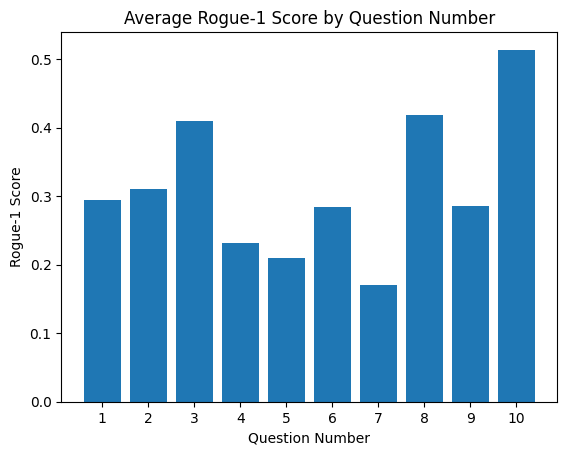

In [ ]:
# Create a bar chart
plt.bar(avg_rogue1["Question Number"], avg_rogue1["Rogue-1"])
plt.xlabel("Question Number")
plt.ylabel("Rogue-1 Score")
plt.title("Average Rogue-1 Score by Question Number")
plt.xticks(avg_rogue1["Question Number"])
plt.show()

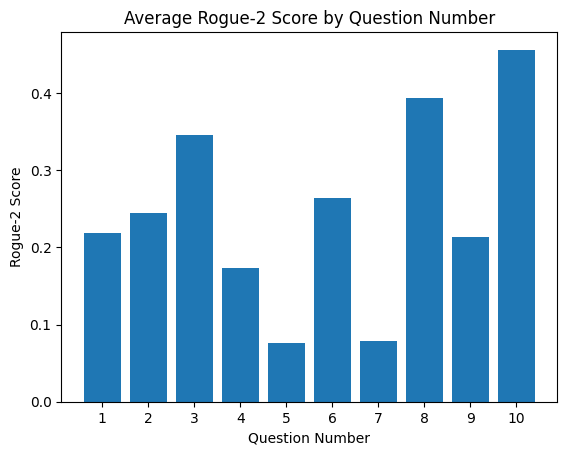

In [ ]:
# Create a bar chart
plt.bar(avg_rogue2["Question Number"], avg_rogue2["Rogue-2"])
plt.xlabel("Question Number")
plt.ylabel("Rogue-2 Score")
plt.title("Average Rogue-2 Score by Question Number")
plt.xticks(avg_rogue2["Question Number"])
plt.show()

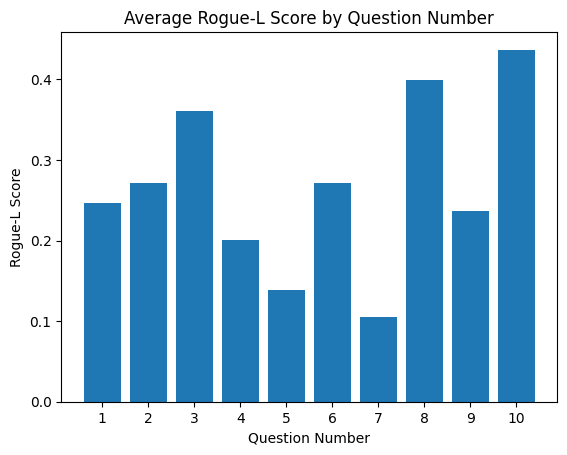

In [ ]:
# Create a bar chart
plt.bar(avg_rogueL["Question Number"], avg_rogueL["Rogue-L"])
plt.xlabel("Question Number")
plt.ylabel("Rogue-L Score")
plt.title("Average Rogue-L Score by Question Number")
plt.xticks(avg_rogueL["Question Number"])
plt.show()

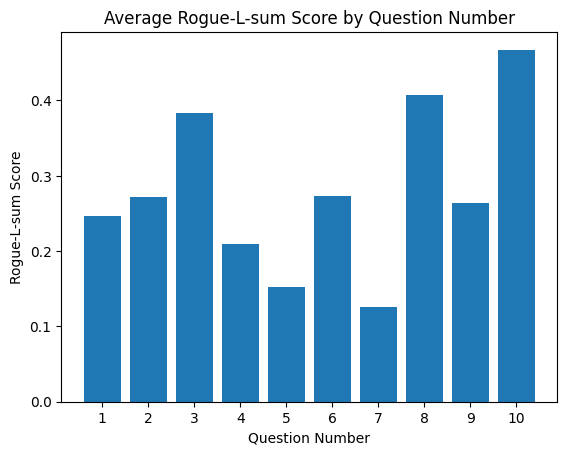

In [ ]:
# Create a bar chart
plt.bar(avg_rogueLsum["Question Number"], avg_rogueLsum["Rogue-L-sum"])
plt.xlabel("Question Number")
plt.ylabel("Rogue-L-sum Score")
plt.title("Average Rogue-L-sum Score by Question Number")
plt.xticks(avg_rogueLsum["Question Number"])
plt.show()

####BLEURT

BLEURT tries to mimic human judgment by scoring how fluent, relevant and factually correct a generated response is compared to a reference. It is good for fluency + meaning-based evaluation, tolerating different wordings, and evaluating summaries, QA or paraphrasings.

In [ ]:
# Create subframe of BLEURT averages
avg_bleurt = results.groupby(["Question Number", "Question"])["BLEURT"].mean()
avg_bleurt = avg_bleurt.reset_index()

In [ ]:
avg_bleurt

,Question Number,Question,BLEURT
0,1,What is a stroke?,0.107557
1,2,How does asthma affect the respiratory system?,-0.075598
2,3,What are the common causes for anemia?,-0.416630
3,4,How can someone reduce their risk of developin...,-1.219556
4,5,What are the main differences between viral an...,-0.683971
5,6,What are the symptoms of depression?,-0.681860
6,7,What are the key signs of early onset Alzheime...,-0.740924
7,8,How is Lyme disease transmitted?,-0.839526
8,9,What are the symptoms of HPV?,-0.975758
9,10,What should pregnant individuals know about pr...,-0.633293


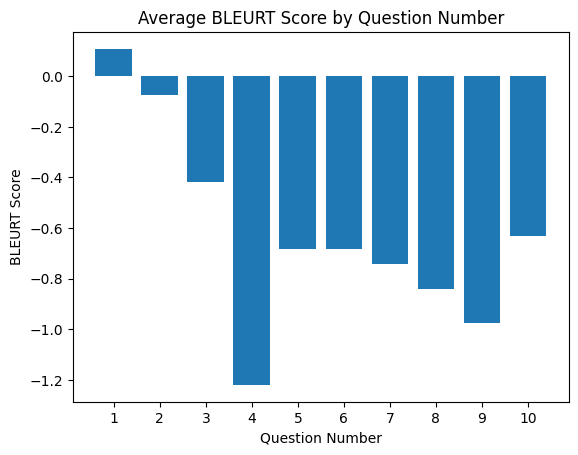

In [ ]:
# Create bar chart
plt.bar(avg_bleurt["Question Number"], avg_bleurt["BLEURT"])
plt.xlabel("Question Number")
plt.ylabel("BLEURT Score")
plt.title("Average BLEURT Score by Question Number")
plt.xticks(avg_bleurt["Question Number"])
plt.show()

####DeBERTa

DeBERTa is a language model architecture that improves over BERT and RoBERTa by using disentangled attention, applying relative positional encodings and pretraining with a larger-scale corpus. In this case, it is fine-tuned on a Natural Language Inference (NLI) task to evaluate faithfulness/hallucinations in the QA system.

In [ ]:
# Create DeBERTa label counts subframe
deberta_counts = results.groupby(["Question Number", "Question", "Faithfulness"]).size().unstack(fill_value=0)
deberta_counts = deberta_counts.reset_index()

In [ ]:
deberta_counts

Faithfulness,Question Number,Question,ENTAILMENT,NEUTRAL
0,1,What is a stroke?,4,2
1,2,How does asthma affect the respiratory system?,4,2
2,3,What are the common causes for anemia?,6,0
3,4,How can someone reduce their risk of developin...,4,2
4,5,What are the main differences between viral an...,3,3
5,6,What are the symptoms of depression?,3,3
6,7,What are the key signs of early onset Alzheime...,2,4
7,8,How is Lyme disease transmitted?,4,2
8,9,What are the symptoms of HPV?,3,3
9,10,What should pregnant individuals know about pr...,6,0


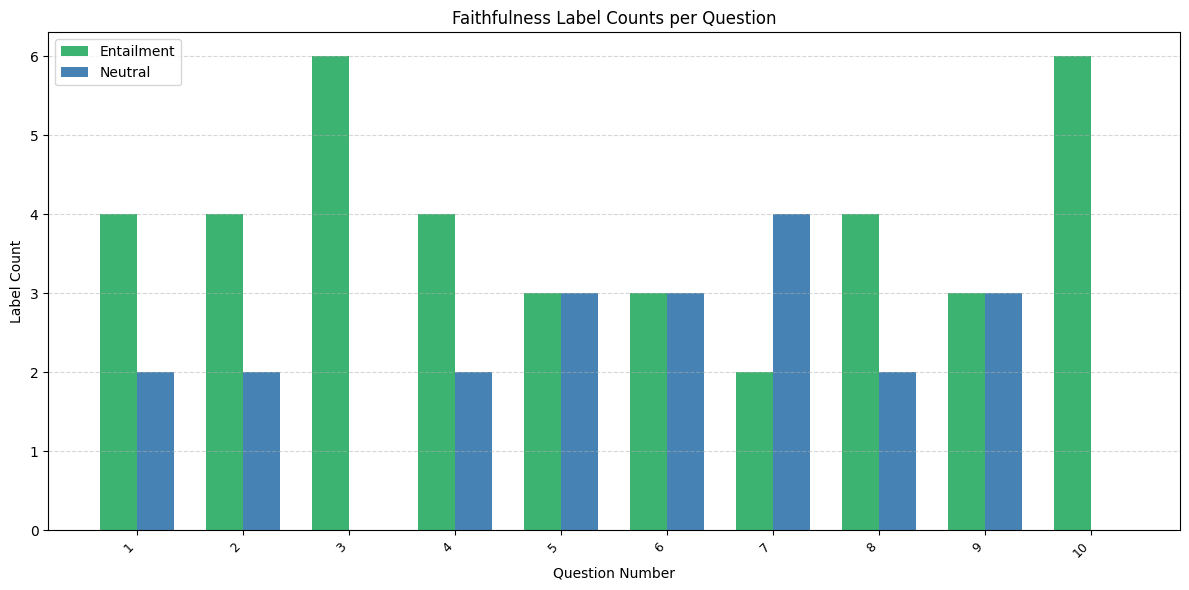

In [ ]:
# Set bar positions
x = np.arange(len(deberta_counts))
width = 0.35  # width of each bar

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, deberta_counts["ENTAILMENT"], width, label='Entailment', color='mediumseagreen')
bars2 = ax.bar(x + width/2, deberta_counts["NEUTRAL"], width, label='Neutral', color='steelblue')

# Labels and ticks
ax.set_xlabel("Question Number")
ax.set_ylabel("Label Count")
ax.set_title("Faithfulness Label Counts per Question")
ax.set_xticks(x)
ax.set_xticklabels(deberta_counts["Question Number"], rotation=45, ha="right", fontsize=9)
ax.legend()

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

####Human Evaluation

#####Factual Accuracy

In [ ]:
question_he_accu_scores = results.groupby(["Question Number", "Question", "HE Factual Accuracy"]).size().unstack(fill_value=0)
question_he_accu_scores = question_he_accu_scores.reset_index()

# Compute weighted average score per question
question_he_accu_scores["Average Score"] = (
    question_he_accu_scores[0]*0 +
    question_he_accu_scores[1]*1 +
    question_he_accu_scores[2]*2 +
    question_he_accu_scores[3]*3
) / (
    question_he_accu_scores[[0, 1, 2, 3]].sum(axis=1)
)

question_he_accu_scores

HE Factual Accuracy,Question Number,Question,0,1,2,3,Average Score
0,1,What is a stroke?,0,0,1,5,2.833333
1,2,How does asthma affect the respiratory system?,0,0,0,6,3.000000
2,3,What are the common causes for anemia?,0,0,4,2,2.333333
3,4,How can someone reduce their risk of developin...,3,0,0,3,1.500000
4,5,What are the main differences between viral an...,1,0,4,1,1.833333
5,6,What are the symptoms of depression?,1,1,2,2,1.833333
6,7,What are the key signs of early onset Alzheime...,1,0,4,1,1.833333
7,8,How is Lyme disease transmitted?,0,0,2,4,2.666667
8,9,What are the symptoms of HPV?,1,1,2,2,1.833333
9,10,What should pregnant individuals know about pr...,0,2,3,1,1.833333


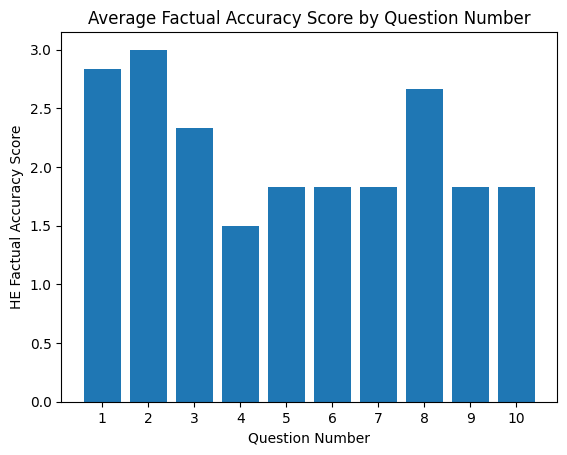

In [ ]:
# Create bar chart
plt.bar(question_he_accu_scores["Question Number"], question_he_accu_scores["Average Score"])
plt.xlabel("Question Number")
plt.ylabel("HE Factual Accuracy Score")
plt.title("Average Factual Accuracy Score by Question Number")
plt.xticks(question_he_accu_scores["Question Number"])
plt.show()

#####Relevance

In [ ]:
question_he_rel_scores = results.groupby(["Question Number", "Question", "HE Relevance"]).size().unstack(fill_value=0)
question_he_rel_scores = question_he_rel_scores.reset_index()

# Compute weighted average score per question
question_he_rel_scores["Average Score"] = (
    question_he_rel_scores[0]*0 +
    question_he_rel_scores[1]*1 +
    question_he_rel_scores[2]*2 +
    question_he_rel_scores[3]*3
) / (
    question_he_rel_scores[[0, 1, 2, 3]].sum(axis=1)
)

question_he_rel_scores

HE Relevance,Question Number,Question,0,1,2,3,Average Score
0,1,What is a stroke?,0,0,1,5,2.833333
1,2,How does asthma affect the respiratory system?,0,0,2,4,2.666667
2,3,What are the common causes for anemia?,0,0,1,5,2.833333
3,4,How can someone reduce their risk of developin...,3,0,0,3,1.500000
4,5,What are the main differences between viral an...,1,0,2,3,2.166667
5,6,What are the symptoms of depression?,1,0,1,4,2.333333
6,7,What are the key signs of early onset Alzheime...,1,0,2,3,2.166667
7,8,How is Lyme disease transmitted?,0,0,3,3,2.500000
8,9,What are the symptoms of HPV?,1,1,1,3,2.000000
9,10,What should pregnant individuals know about pr...,0,0,3,3,2.500000


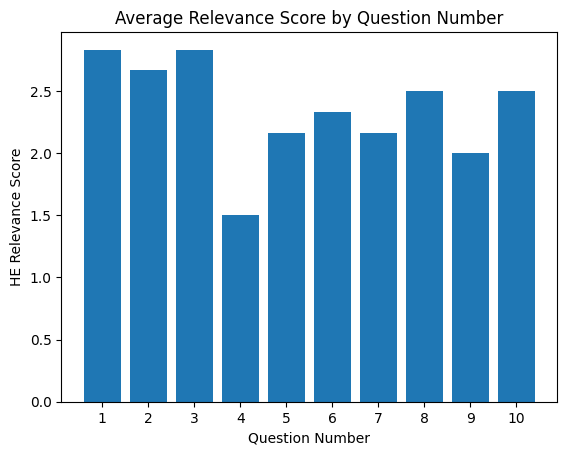

In [ ]:
# Create bar chart
plt.bar(question_he_rel_scores["Question Number"], question_he_rel_scores["Average Score"])
plt.xlabel("Question Number")
plt.ylabel("HE Relevance Score")
plt.title("Average Relevance Score by Question Number")
plt.xticks(question_he_rel_scores["Question Number"])
plt.show()

#####Completeness

In [ ]:
question_he_comp_scores = results.groupby(["Question Number", "Question", "HE Completeness"]).size().unstack(fill_value=0)
question_he_comp_scores = question_he_comp_scores.reset_index()

# Compute weighted average score per question
question_he_comp_scores["Average Score"] = (
    question_he_comp_scores[0]*0 +
    question_he_comp_scores[1]*1 +
    question_he_comp_scores[2]*2 +
    question_he_comp_scores[3]*3
) / (
    question_he_comp_scores[[0, 1, 2, 3]].sum(axis=1)
)

question_he_comp_scores

HE Completeness,Question Number,Question,0,1,2,3,Average Score
0,1,What is a stroke?,0,2,3,1,1.833333
1,2,How does asthma affect the respiratory system?,1,0,4,1,1.833333
2,3,What are the common causes for anemia?,1,2,1,2,1.666667
3,4,How can someone reduce their risk of developin...,3,0,2,1,1.166667
4,5,What are the main differences between viral an...,3,0,3,0,1.000000
5,6,What are the symptoms of depression?,2,0,3,1,1.500000
6,7,What are the key signs of early onset Alzheime...,2,2,1,1,1.166667
7,8,How is Lyme disease transmitted?,2,2,1,1,1.166667
8,9,What are the symptoms of HPV?,1,2,3,0,1.333333
9,10,What should pregnant individuals know about pr...,1,5,0,0,0.833333


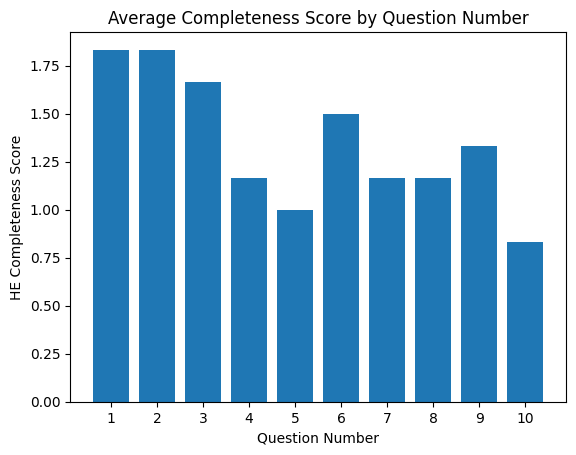

In [ ]:
# Create bar chart
plt.bar(question_he_comp_scores["Question Number"], question_he_comp_scores["Average Score"])
plt.xlabel("Question Number")
plt.ylabel("HE Completeness Score")
plt.title("Average Completeness Score by Question Number")
plt.xticks(question_he_comp_scores["Question Number"])
plt.show()

#####Clarity

In [ ]:
question_he_clar_scores = results.groupby(["Question Number", "Question", "HE Clarity"]).size().unstack(fill_value=0)
question_he_clar_scores = question_he_clar_scores.reset_index()

# Compute weighted average score per question
question_he_clar_scores["Average Score"] = (
    question_he_clar_scores[0]*0 +
    question_he_clar_scores[1]*1 +
    question_he_clar_scores[2]*2 +
    question_he_clar_scores[3]*3
) / (
    question_he_clar_scores[[0, 1, 2, 3]].sum(axis=1)
)

question_he_clar_scores

HE Clarity,Question Number,Question,0,1,2,3,Average Score
0,1,What is a stroke?,0,0,3,3,2.500000
1,2,How does asthma affect the respiratory system?,0,0,3,3,2.500000
2,3,What are the common causes for anemia?,0,1,3,2,2.166667
3,4,How can someone reduce their risk of developin...,3,0,0,3,1.500000
4,5,What are the main differences between viral an...,1,3,1,1,1.333333
5,6,What are the symptoms of depression?,1,2,2,1,1.500000
6,7,What are the key signs of early onset Alzheime...,1,0,3,2,2.000000
7,8,How is Lyme disease transmitted?,0,0,4,2,2.333333
8,9,What are the symptoms of HPV?,1,1,3,1,1.666667
9,10,What should pregnant individuals know about pr...,0,3,3,0,1.500000


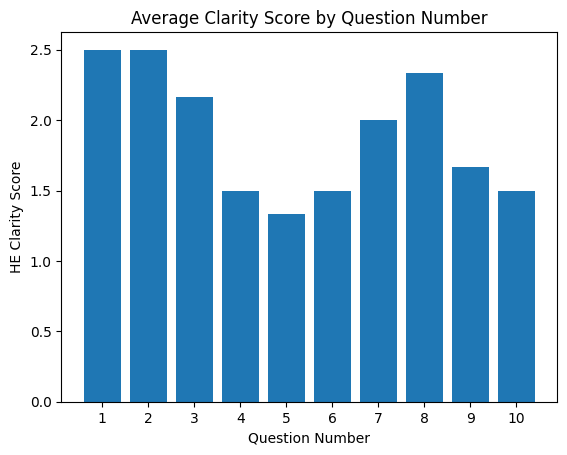

In [ ]:
# Create bar chart
plt.bar(question_he_clar_scores["Question Number"], question_he_clar_scores["Average Score"])
plt.xlabel("Question Number")
plt.ylabel("HE Clarity Score")
plt.title("Average Clarity Score by Question Number")
plt.xticks(question_he_clar_scores["Question Number"])
plt.show()

###Model Performance Analysis

####Rogue

In [ ]:
# Create subframe of ROGUE averages
avg_rogue1 = results.groupby("Model")["Rogue-1"].mean()
avg_rogue2 = results.groupby("Model")["Rogue-2"].mean()
avg_rogueL = results.groupby("Model")["Rogue-L"].mean()
avg_rogueLsum = results.groupby("Model")["Rogue-L-sum"].mean()

avg_rogue1 = avg_rogue1.reset_index()
avg_rogue2 = avg_rogue2.reset_index()
avg_rogueL = avg_rogueL.reset_index()
avg_rogueLsum = avg_rogueLsum.reset_index()

In [ ]:
avg_rogue1

,Model,Rogue-1
0,llama,0.262178
1,mistral,0.197779
2,phi,0.478512


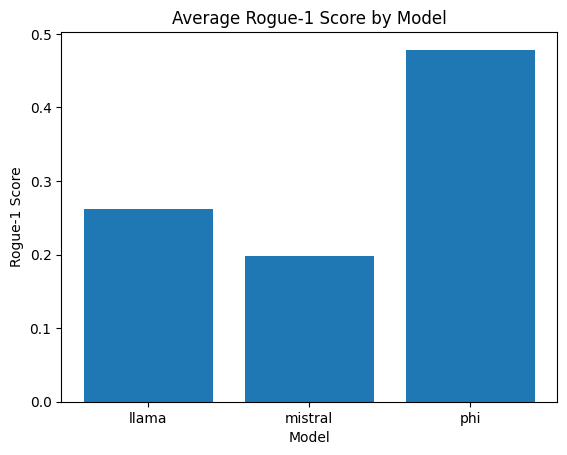

In [ ]:
# Create a bar chart
plt.bar(avg_rogue1["Model"], avg_rogue1["Rogue-1"])
plt.xlabel("Model")
plt.ylabel("Rogue-1 Score")
plt.title("Average Rogue-1 Score by Model")
plt.xticks(avg_rogue1["Model"])
plt.show()

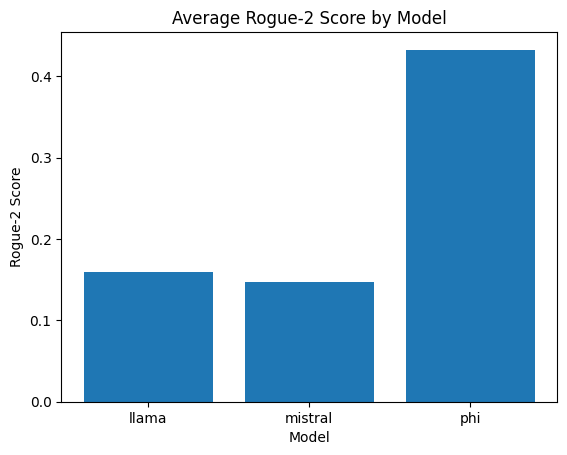

In [ ]:
# Create a bar chart
plt.bar(avg_rogue2["Model"], avg_rogue2["Rogue-2"])
plt.xlabel("Model")
plt.ylabel("Rogue-2 Score")
plt.title("Average Rogue-2 Score by Model")
plt.xticks(avg_rogue2["Model"])
plt.show()

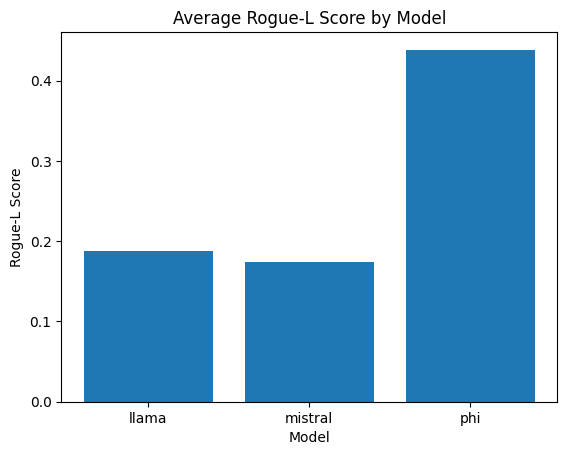

In [ ]:
# Create a bar chart
plt.bar(avg_rogueL["Model"], avg_rogueL["Rogue-L"])
plt.xlabel("Model")
plt.ylabel("Rogue-L Score")
plt.title("Average Rogue-L Score by Model")
plt.xticks(avg_rogueL["Model"])
plt.show()

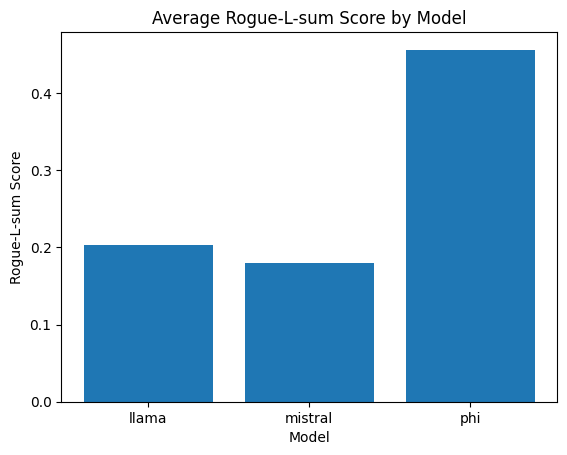

In [ ]:
# Create a bar chart
plt.bar(avg_rogueLsum["Model"], avg_rogueLsum["Rogue-L-sum"])
plt.xlabel("Model")
plt.ylabel("Rogue-L-sum Score")
plt.title("Average Rogue-L-sum Score by Model")
plt.xticks(avg_rogueLsum["Model"])
plt.show()

####BLEURT

In [ ]:
# Create subframe of BLEURT averages
avg_bleurt = results.groupby("Model")["BLEURT"].mean()
avg_bleurt = avg_bleurt.reset_index()

In [ ]:
avg_bleurt

,Model,BLEURT
0,llama,-0.646751
1,mistral,-0.714154
2,phi,-0.486963


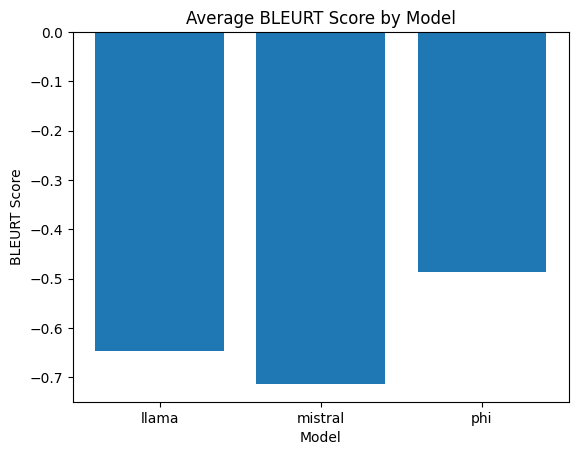

In [ ]:
# Create bar chart
plt.bar(avg_bleurt["Model"], avg_bleurt["BLEURT"])
plt.xlabel("Model")
plt.ylabel("BLEURT Score")
plt.title("Average BLEURT Score by Model")
plt.xticks(avg_bleurt["Model"])
plt.show()

####DeBERTa

In [ ]:
# Create DeBERTa label counts subframe
deberta_counts = results.groupby(["Model", "Faithfulness"]).size().unstack(fill_value=0)
deberta_counts = deberta_counts.reset_index()

In [ ]:
deberta_counts

Faithfulness,Model,ENTAILMENT,NEUTRAL
0,llama,10,10
1,mistral,13,7
2,phi,16,4


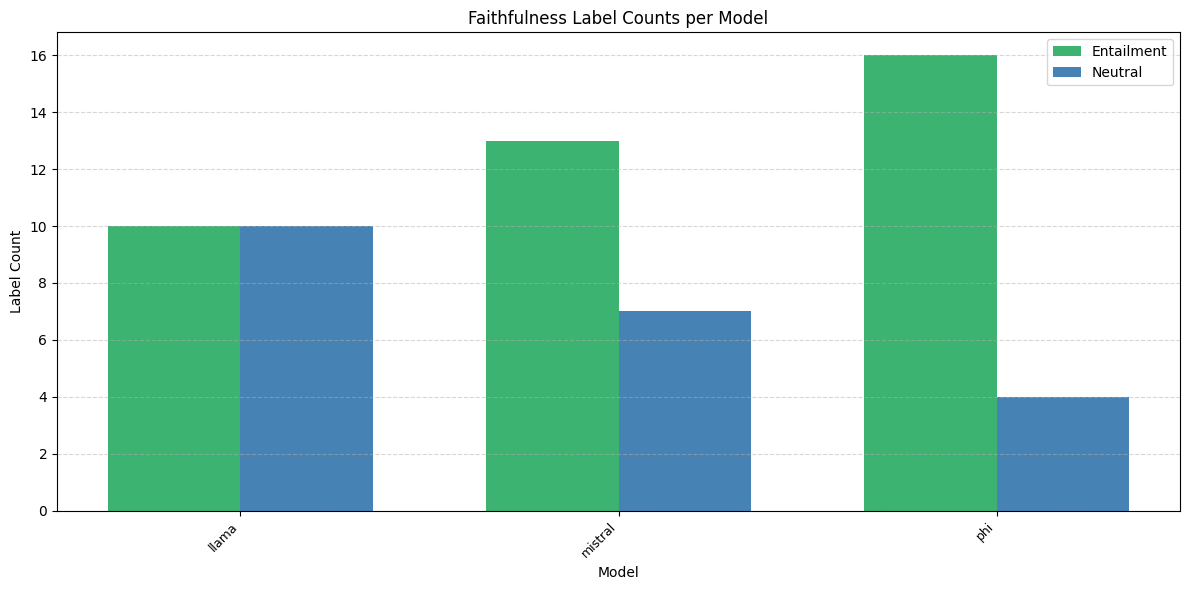

In [ ]:
# Set bar positions
x = np.arange(len(deberta_counts))
width = 0.35  # width of each bar

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, deberta_counts["ENTAILMENT"], width, label='Entailment', color='mediumseagreen')
bars2 = ax.bar(x + width/2, deberta_counts["NEUTRAL"], width, label='Neutral', color='steelblue')

# Labels and ticks
ax.set_xlabel("Model")
ax.set_ylabel("Label Count")
ax.set_title("Faithfulness Label Counts per Model")
ax.set_xticks(x)
ax.set_xticklabels(deberta_counts["Model"], rotation=45, ha="right", fontsize=9)
ax.legend()

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

####Human Evaluation

#####Factual Accuracy

In [ ]:
model_he_accu_scores = results.groupby(["Model", "HE Factual Accuracy"]).size().unstack(fill_value=0)
model_he_accu_scores = model_he_accu_scores.reset_index()

# Compute weighted average score per model
model_he_accu_scores["Average Score"] = (
    model_he_accu_scores[0]*0 +
    model_he_accu_scores[1]*1 +
    model_he_accu_scores[2]*2 +
    model_he_accu_scores[3]*3
) / (
    model_he_accu_scores[[0, 1, 2, 3]].sum(axis=1)
)

model_he_accu_scores

HE Factual Accuracy,Model,0,1,2,3,Average Score
0,llama,3,1,4,12,2.25
1,mistral,2,1,7,10,2.25
2,phi,2,2,11,5,1.95


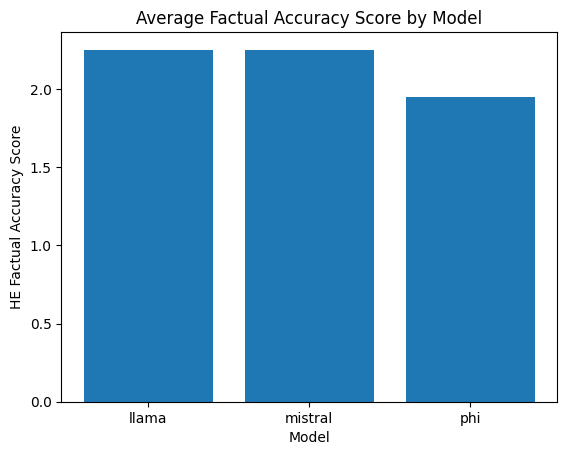

In [ ]:
# Create bar chart
plt.bar(model_he_accu_scores["Model"], model_he_accu_scores["Average Score"])
plt.xlabel("Model")
plt.ylabel("HE Factual Accuracy Score")
plt.title("Average Factual Accuracy Score by Model")
plt.xticks(model_he_accu_scores["Model"])
plt.show()

#####Relevance

In [ ]:
model_he_rel_scores = results.groupby(["Model", "HE Relevance"]).size().unstack(fill_value=0)
model_he_rel_scores = model_he_rel_scores.reset_index()

# Compute weighted average score per model
model_he_rel_scores["Average Score"] = (
    model_he_rel_scores[0]*0 +
    model_he_rel_scores[1]*1 +
    model_he_rel_scores[2]*2 +
    model_he_rel_scores[3]*3
) / (
    model_he_rel_scores[[0, 1, 2, 3]].sum(axis=1)
)

model_he_rel_scores

HE Relevance,Model,0,1,2,3,Average Score
0,llama,3,0,4,13,2.35
1,mistral,2,0,3,15,2.55
2,phi,2,1,9,8,2.15


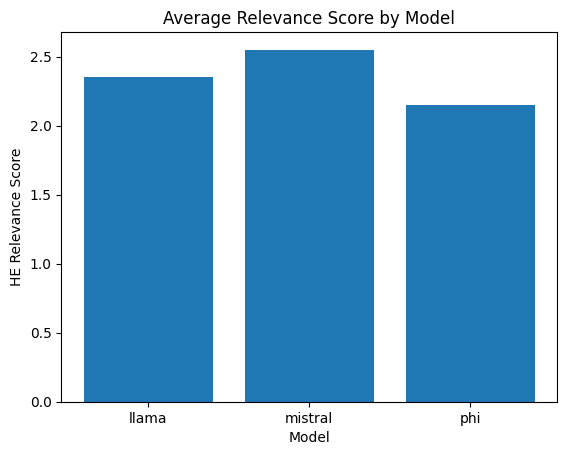

In [ ]:
# Create bar chart
plt.bar(model_he_rel_scores["Model"], model_he_rel_scores["Average Score"])
plt.xlabel("Model")
plt.ylabel("HE Relevance Score")
plt.title("Average Relevance Score by Model")
plt.xticks(model_he_rel_scores["Model"])
plt.show()

#####Completeness

In [ ]:
model_he_comp_scores = results.groupby(["Model", "HE Completeness"]).size().unstack(fill_value=0)
model_he_comp_scores = model_he_comp_scores.reset_index()

# Compute weighted average score per model
model_he_comp_scores["Average Score"] = (
    model_he_comp_scores[0]*0 +
    model_he_comp_scores[1]*1 +
    model_he_comp_scores[2]*2 +
    model_he_comp_scores[3]*3
) / (
    model_he_comp_scores[[0, 1, 2, 3]].sum(axis=1)
)

model_he_comp_scores

HE Completeness,Model,0,1,2,3,Average Score
0,llama,5,2,9,4,1.60
1,mistral,7,7,3,3,1.10
2,phi,4,6,9,1,1.35


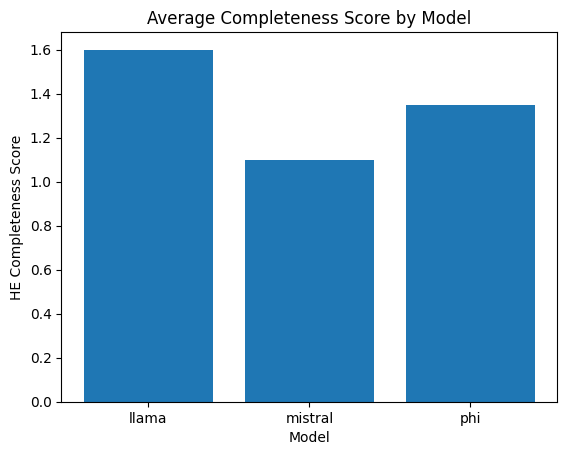

In [ ]:
# Create bar chart
plt.bar(model_he_comp_scores["Model"], model_he_comp_scores["Average Score"])
plt.xlabel("Model")
plt.ylabel("HE Completeness Score")
plt.title("Average Completeness Score by Model")
plt.xticks(model_he_comp_scores["Model"])
plt.show()

#####Clarity

In [ ]:
model_he_clar_scores = results.groupby(["Model", "HE Clarity"]).size().unstack(fill_value=0)
model_he_clar_scores = model_he_clar_scores.reset_index()

# Compute weighted average score per model
model_he_clar_scores["Average Score"] = (
    model_he_clar_scores[0]*0 +
    model_he_clar_scores[1]*1 +
    model_he_clar_scores[2]*2 +
    model_he_clar_scores[3]*3
) / (
    model_he_clar_scores[[0, 1, 2, 3]].sum(axis=1)
)

model_he_clar_scores

HE Clarity,Model,0,1,2,3,Average Score
0,llama,3,2,5,10,2.1
1,mistral,2,4,8,6,1.9
2,phi,2,4,12,2,1.7


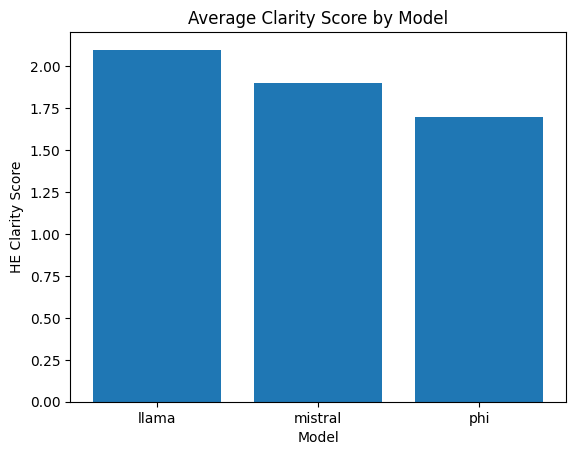

In [ ]:
# Create bar chart
plt.bar(model_he_clar_scores["Model"], model_he_clar_scores["Average Score"])
plt.xlabel("Model")
plt.ylabel("HE Clarity Score")
plt.title("Average Clarity Score by Model")
plt.xticks(model_he_clar_scores["Model"])
plt.show()

###Corpus Performance Analysis

####Rogue

In [ ]:
# Create subframe of ROGUE averages
avg_rogue1 = results.groupby("Corpus")["Rogue-1"].mean()
avg_rogue2 = results.groupby("Corpus")["Rogue-2"].mean()
avg_rogueL = results.groupby("Corpus")["Rogue-L"].mean()
avg_rogueLsum = results.groupby("Corpus")["Rogue-L-sum"].mean()

avg_rogue1 = avg_rogue1.reset_index()
avg_rogue2 = avg_rogue2.reset_index()
avg_rogueL = avg_rogueL.reset_index()
avg_rogueLsum = avg_rogueLsum.reset_index()

In [ ]:
avg_rogue1

,Corpus,Rogue-1
0,Medline,0.271197
1,Medquad,0.354449


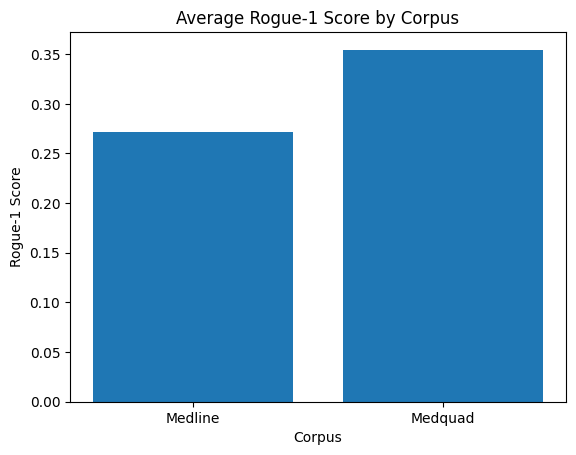

In [ ]:
# Create a bar chart
plt.bar(avg_rogue1["Corpus"], avg_rogue1["Rogue-1"])
plt.xlabel("Corpus")
plt.ylabel("Rogue-1 Score")
plt.title("Average Rogue-1 Score by Corpus")
plt.xticks(avg_rogue1["Corpus"])
plt.show()

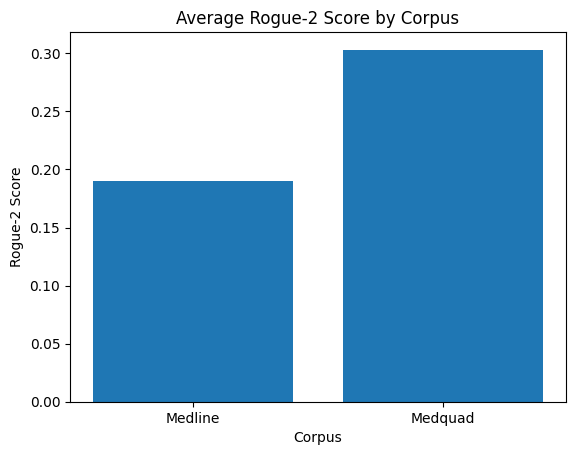

In [ ]:
# Create a bar chart
plt.bar(avg_rogue2["Corpus"], avg_rogue2["Rogue-2"])
plt.xlabel("Corpus")
plt.ylabel("Rogue-2 Score")
plt.title("Average Rogue-2 Score by Corpus")
plt.xticks(avg_rogue2["Corpus"])
plt.show()

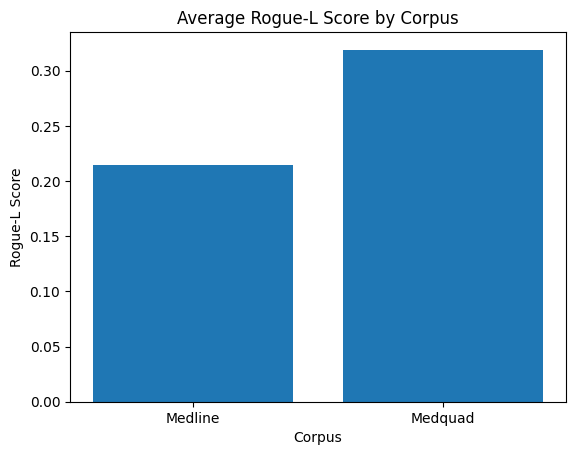

In [ ]:
# Create a bar chart
plt.bar(avg_rogueL["Corpus"], avg_rogueL["Rogue-L"])
plt.xlabel("Corpus")
plt.ylabel("Rogue-L Score")
plt.title("Average Rogue-L Score by Corpus")
plt.xticks(avg_rogueL["Corpus"])
plt.show()

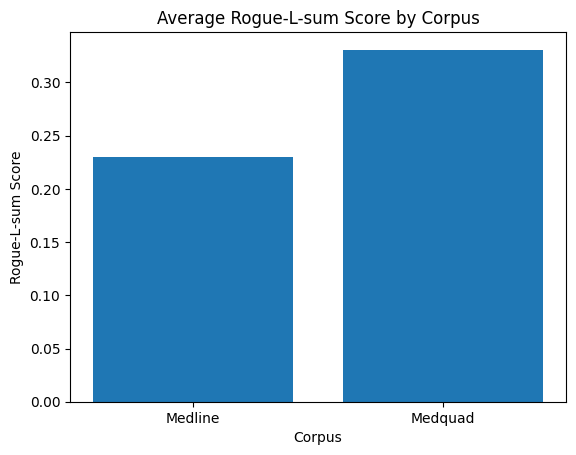

In [ ]:
# Create a bar chart
plt.bar(avg_rogueLsum["Corpus"], avg_rogueLsum["Rogue-L-sum"])
plt.xlabel("Corpus")
plt.ylabel("Rogue-L-sum Score")
plt.title("Average Rogue-L-sum Score by Corpus")
plt.xticks(avg_rogueLsum["Corpus"])
plt.show()

####BLEURT

In [ ]:
# Create subframe of BLEURT averages
avg_bleurt = results.groupby("Corpus")["BLEURT"].mean()
avg_bleurt = avg_bleurt.reset_index()

In [ ]:
avg_bleurt

,Corpus,BLEURT
0,Medline,-0.521596
1,Medquad,-0.710316


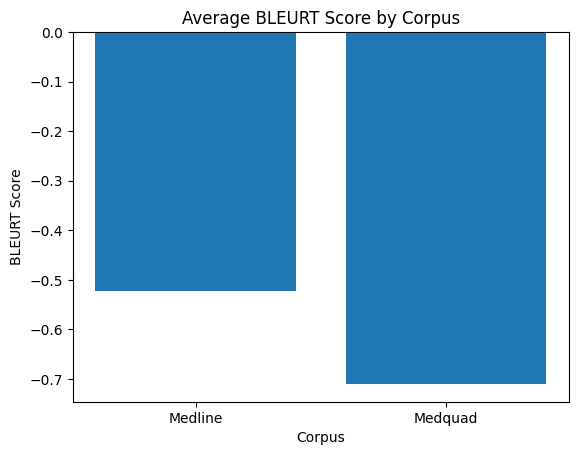

In [ ]:
# Create bar chart
plt.bar(avg_bleurt["Corpus"], avg_bleurt["BLEURT"])
plt.xlabel("Corpus")
plt.ylabel("BLEURT Score")
plt.title("Average BLEURT Score by Corpus")
plt.xticks(avg_bleurt["Corpus"])
plt.show()

####DeBERTa

In [ ]:
# Create DeBERTa label counts subframe
deberta_counts = results.groupby(["Corpus", "Faithfulness"]).size().unstack(fill_value=0)
deberta_counts = deberta_counts.reset_index()

In [ ]:
deberta_counts

Faithfulness,Corpus,ENTAILMENT,NEUTRAL
0,Medline,16,14
1,Medquad,23,7


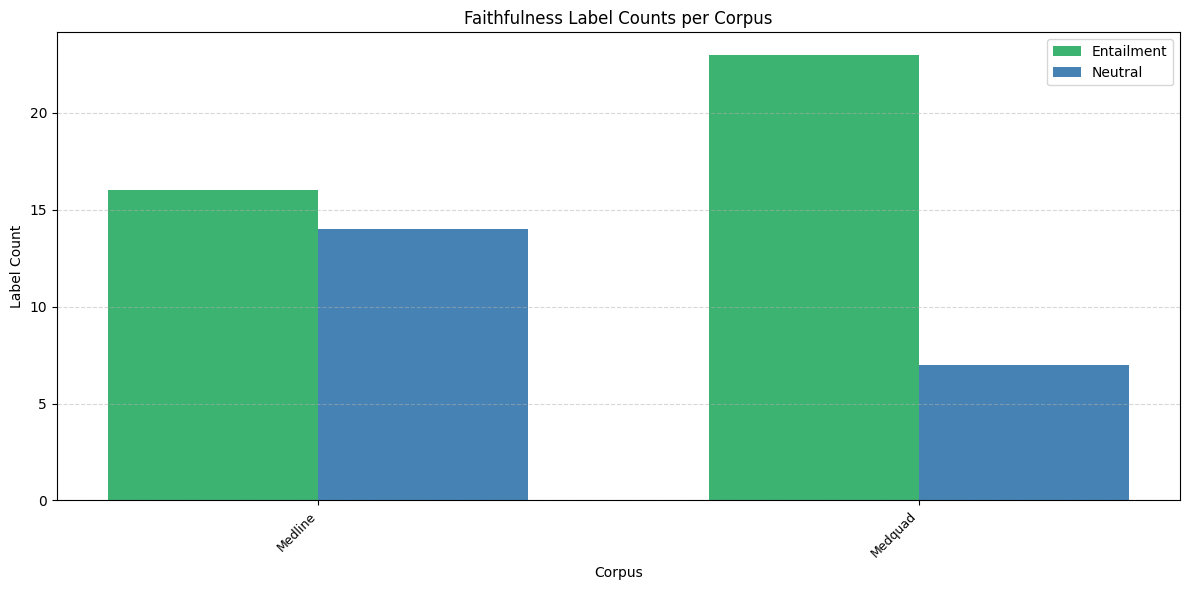

In [ ]:
# Set bar positions
x = np.arange(len(deberta_counts))
width = 0.35  # width of each bar

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, deberta_counts["ENTAILMENT"], width, label='Entailment', color='mediumseagreen')
bars2 = ax.bar(x + width/2, deberta_counts["NEUTRAL"], width, label='Neutral', color='steelblue')

# Labels and ticks
ax.set_xlabel("Corpus")
ax.set_ylabel("Label Count")
ax.set_title("Faithfulness Label Counts per Corpus")
ax.set_xticks(x)
ax.set_xticklabels(deberta_counts["Corpus"], rotation=45, ha="right", fontsize=9)
ax.legend()

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

####Human Evaluation

#####Factual Accuracy

In [ ]:
corpus_he_accu_scores = results.groupby(["Corpus", "HE Factual Accuracy"]).size().unstack(fill_value=0)
corpus_he_accu_scores = corpus_he_accu_scores.reset_index()

# Compute weighted average score per corpus
corpus_he_accu_scores["Average Score"] = (
    corpus_he_accu_scores[0]*0 +
    corpus_he_accu_scores[1]*1 +
    corpus_he_accu_scores[2]*2 +
    corpus_he_accu_scores[3]*3
) / (
    corpus_he_accu_scores[[0, 1, 2, 3]].sum(axis=1)
)

corpus_he_accu_scores

HE Factual Accuracy,Corpus,0,1,2,3,Average Score
0,Medline,1,3,11,15,2.333333
1,Medquad,6,1,11,12,1.966667


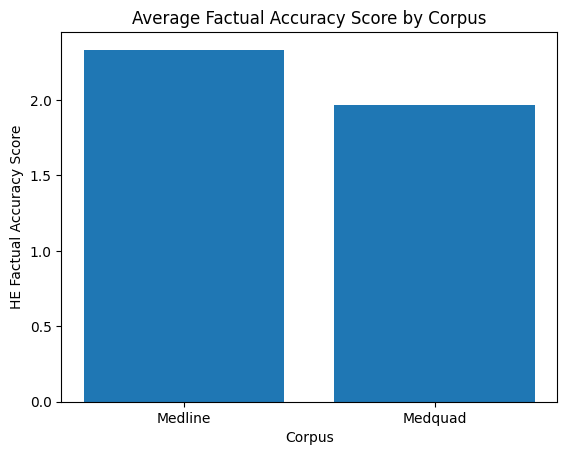

In [ ]:
# Create bar chart
plt.bar(corpus_he_accu_scores["Corpus"], corpus_he_accu_scores["Average Score"])
plt.xlabel("Corpus")
plt.ylabel("HE Factual Accuracy Score")
plt.title("Average Factual Accuracy Score by Corpus")
plt.xticks(corpus_he_accu_scores["Corpus"])
plt.show()

#####Relevance

In [ ]:
corpus_he_rel_scores = results.groupby(["Corpus", "HE Relevance"]).size().unstack(fill_value=0)
corpus_he_rel_scores = corpus_he_rel_scores.reset_index()

# Compute weighted average score per corpus
corpus_he_rel_scores["Average Score"] = (
    corpus_he_rel_scores[0]*0 +
    corpus_he_rel_scores[1]*1 +
    corpus_he_rel_scores[2]*2 +
    corpus_he_rel_scores[3]*3
) / (
    corpus_he_rel_scores[[0, 1, 2, 3]].sum(axis=1)
)

corpus_he_rel_scores

HE Relevance,Corpus,0,1,2,3,Average Score
0,Medline,1,0,10,19,2.566667
1,Medquad,6,1,6,17,2.133333


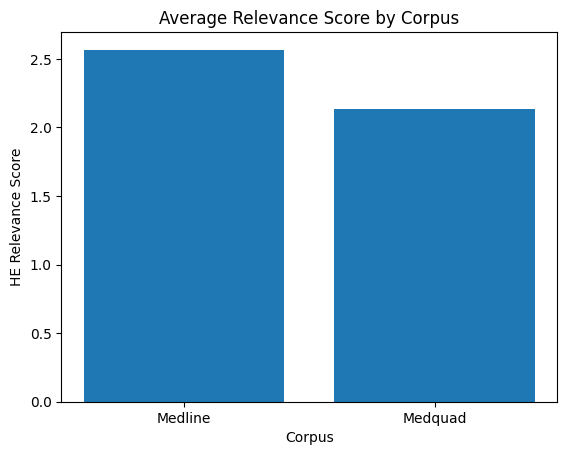

In [ ]:
# Create bar chart
plt.bar(corpus_he_rel_scores["Corpus"], corpus_he_rel_scores["Average Score"])
plt.xlabel("Corpus")
plt.ylabel("HE Relevance Score")
plt.title("Average Relevance Score by Corpus")
plt.xticks(corpus_he_rel_scores["Corpus"])
plt.show()

#####Completeness

In [ ]:
corpus_he_comp_scores = results.groupby(["Corpus", "HE Completeness"]).size().unstack(fill_value=0)
corpus_he_comp_scores = corpus_he_comp_scores.reset_index()

# Compute weighted average score per corpus
corpus_he_comp_scores["Average Score"] = (
    corpus_he_comp_scores[0]*0 +
    corpus_he_comp_scores[1]*1 +
    corpus_he_comp_scores[2]*2 +
    corpus_he_comp_scores[3]*3
) / (
    corpus_he_comp_scores[[0, 1, 2, 3]].sum(axis=1)
)

corpus_he_comp_scores

HE Completeness,Corpus,0,1,2,3,Average Score
0,Medline,3,8,13,6,1.733333
1,Medquad,13,7,8,2,0.966667


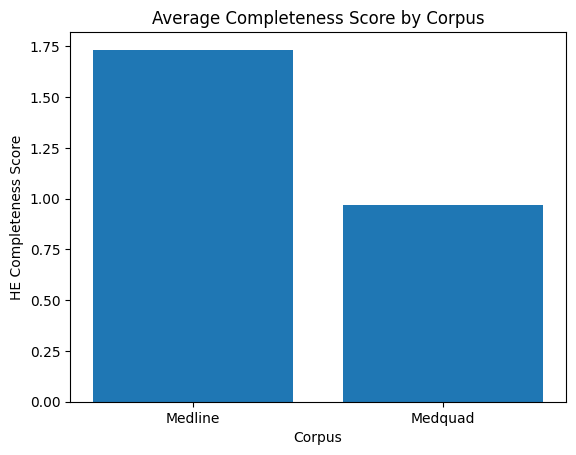

In [ ]:
# Create bar chart
plt.bar(corpus_he_comp_scores["Corpus"], corpus_he_comp_scores["Average Score"])
plt.xlabel("Corpus")
plt.ylabel("HE Completeness Score")
plt.title("Average Completeness Score by Corpus")
plt.xticks(corpus_he_comp_scores["Corpus"])
plt.show()

#####Clarity

In [ ]:
corpus_he_clar_scores = results.groupby(["Corpus", "HE Clarity"]).size().unstack(fill_value=0)
corpus_he_clar_scores = corpus_he_clar_scores.reset_index()

# Compute weighted average score per corpus
corpus_he_clar_scores["Average Score"] = (
    corpus_he_clar_scores[0]*0 +
    corpus_he_clar_scores[1]*1 +
    corpus_he_clar_scores[2]*2 +
    corpus_he_clar_scores[3]*3
) / (
    corpus_he_clar_scores[[0, 1, 2, 3]].sum(axis=1)
)

corpus_he_clar_scores

HE Clarity,Corpus,0,1,2,3,Average Score
0,Medline,1,5,11,13,2.2
1,Medquad,6,5,14,5,1.6


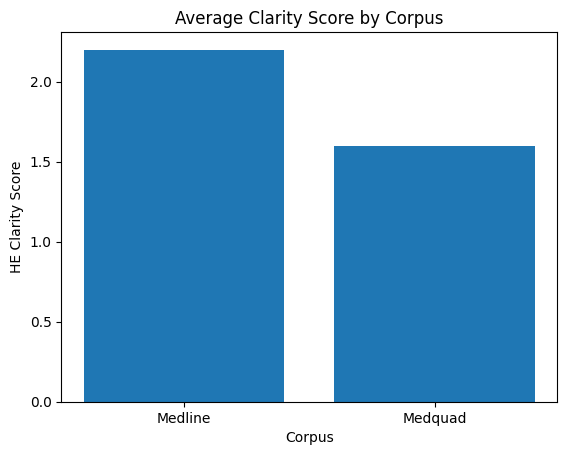

In [ ]:
# Create bar chart
plt.bar(corpus_he_clar_scores["Corpus"], corpus_he_clar_scores["Average Score"])
plt.xlabel("Corpus")
plt.ylabel("HE Clarity Score")
plt.title("Average Clarity Score by Corpus")
plt.xticks(corpus_he_clar_scores["Corpus"])
plt.show()